In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

%matplotlib inline



class NeuralNetwork(nn.Module):
    def __init__(self,input_dim = 1, num_nodes = 32):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_nodes),
            nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            #nn.Dropout(0.3),
            #nn.BatchNorm1d(num_nodes), 
            
            #nn.Linear(num_nodes, num_nodes),
            #nn.ReLU(),
            # # #nn.Dropout(0.3),
            # # nn.BatchNorm1d(num_nodes), 
            
            nn.Linear(num_nodes, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        target = self.linear_relu_stack(x)
        return target
    
class ParameterClipper(object):
    def __init__(self,
                 w_low = -2,
                 w_high = 2,
                 b_low = -2,
                 b_high = 2):
        self.w_low = w_low 
        self.w_high = w_high 
        self.b_low = b_low 
        self.b_high = b_high 

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(self.w_low,self.w_high)
            module.weight.data = w
        if hasattr(module, 'bias'):
            b = module.bias.data
            b = b.clamp(self.b_low,self.b_high)
            module.bias.data = b
            
class ParameterShaker(object):
    def __init__(self,n, sigma = 1e-2):
        self.n = n
        self.sigma = sigma

    def __call__(self, module):
        # filter the variables to get the ones you want
        sigma = self.sigma/torch.sqrt(torch.tensor(self.n, dtype = float))
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w + sigma*torch.normal(0,1,(1,))[0]
            module.weight.data = w
        if hasattr(module, 'bias'):
            b = module.bias.data
            b = b + sigma*torch.normal(0,1,(1,))[0]
            module.bias.data = b

In [2]:
class Adversarial_Balancing():
    def __init__(self,
                 source_sample,
                 target_sample,
                 source_weight = None,
                 target_weight = None):
        """
        Attributes
        ----------
        source_sample: tensor
        Support of the source measure.
        
        target_sample: tensor
        target of the source measure.
        
        source_weight: tensor/np.array or None
        Weights of the source weighted empirical measure, i.e., 
        source measure = \frac{1}{n} \sum_{i=1}^{n} source_weight[i] \delta_{source_sample[i]}. 
        When not assigned, the weight 1 is being implemented.
        
        target_weight: tensor/np.array or None
        Weights of the target weighted empirical measure, i.e., 
        $$
        target measure = \frac{1}{m} \sum_{j=1}^{m} target_weight[j] \delta_{target_sample[j]}. 
        $$
        When not assigned, the weight 1 is being implemented.
        """
        # use GPU when possible
        if torch.cuda.is_available():  
            dev = "cuda:0" 
        else:  
            dev = "cpu"  
        self.dev = torch.device(dev)
        # xi denotes the source measure
        # xi_ring denotes the target measure
        with torch.no_grad():
            self.xi = source_sample.clone().to(self.dev)
            self.xi_ring = target_sample.clone().to(self.dev)
            if source_weight:
                self.w = source_weight.clone().to(self.dev)
            else:
                self.w = torch.ones(len(source_sample)).clone().to(self.dev)
            if target_weight:
                self.w_ring = target_weight.clone().to(self.dev)
            else:
                self.w_ring = torch.ones(len(target_sample)).to(self.dev)
        self.n  = len(self.xi)
                
  
            
    def train_loop(self,
                   model_IPM,
                  model_reweighting,
                  optimizer_IPM,
                  optimizer_reweighting,
                  IPM_steps = 1,
                  reweight_steps = 1,
                  lambda_l2_weight = 1e-1,
                  lambda_l2_IPM = 1e-1,
                  lambda_l1_IPM = 1e-1,
                  ):
        for t in range(IPM_steps):
            with torch.no_grad():
                weights = model_reweighting(self.xi).clone()
            weights.to(self.dev)
            mean_source = torch.mean(model_IPM(self.xi)*weights*self.w)
            #mean_source = torch.mean(model_IPM(self.xi)*weights/weights.sum()*self.w)
            mean_target = torch.mean(model_IPM(self.xi_ring)*self.w_ring)
            loss_IPM = -torch.abs(mean_source - mean_target)
            # # l2-regularization
            # lambda_l2_IPM = 1e2
            # for p in model_IPM.parameters():
            #     l2 += p.square().sum()
            #loss_IPM += lambda_l2_IPM * model_IPM(self.xi).square().mean() 
            loss_IPM_reg = loss_IPM + lambda_l2_IPM * (model_IPM(self.xi).square()*self.w).mean() 
            loss_IPM_reg +=  lambda_l1_IPM*(model_IPM(self.xi_ring).square()*self.w_ring).mean()
            # Backpropagation
            optimizer_IPM.zero_grad()
            loss_IPM_reg.backward()
            optimizer_IPM.step() 
            
            #shaker = ParameterShaker(self.n)
            #model_IPM.apply(shaker)
        # optimization for weight function estimation    
        
        for t in range(reweight_steps):
            with torch.no_grad():
                mean_target_ = torch.mean(model_IPM(self.xi_ring)*self.w_ring).clone()
                values = model_IPM(self.xi).clone()
            mean_source_ =  torch.mean(values*model_reweighting(self.xi)*self.w)
            #mean_source_ =  torch.mean(values*model_reweighting(self.xi)/model_reweighting(self.xi).sum()*self.w)
            loss_reweighting = torch.abs(mean_source_ - mean_target_)
            
            #loss_reweighting_reg = loss_reweighting + lambda_l2_weight * model_reweighting(self.xi).square().mean() 
            loss_reweighting_reg = loss_reweighting + lambda_l2_weight * (model_reweighting(self.xi).square()*self.w).mean() 
            
            optimizer_reweighting.zero_grad()
            loss_reweighting_reg.backward()
            optimizer_reweighting.step() 
            #clipper = ParameterClipper()
            #model_reweighting.apply(clipper)
            
            #shaker = ParameterShaker(self.n)
            #model_reweighting.apply(shaker)
        return loss_reweighting
    
   
    
    
    

In [4]:
n = 500
m = 500
xi = torch.normal(mean = -1, std = 2, size = (n,1))
xi_ring = torch.zeros(size = (m,1))
for i in range(m):
    if torch.rand(1).item()>0.3:
        xi_ring[i,0] = torch.normal(mean = -4, std = 2, size = (1,)).item()
    else:
        xi_ring[i,0] = torch.normal(mean = 3, std = 0.2, size = (1,)).item()

In [5]:

AB = Adversarial_Balancing(xi,xi_ring)


In [6]:
num_nodes_IPM = 16
model_IPM = NeuralNetwork(num_nodes = 2*num_nodes_IPM).to(AB.dev)
model_reweighting = NeuralNetwork(num_nodes = num_nodes_IPM).to(AB.dev)

In [7]:
learning_rate = 1e-3
optimizer_IPM = torch.optim.Adam(model_IPM.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
optimizer_reweighting = torch.optim.Adam(model_reweighting.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)

In [8]:
epochs = 5000
loss_trace = []
# warming up
for t in tqdm(range(epochs)):
    #print(f"Epoch {t+1}\n-------------------------------")
    current_test_loss = AB.train_loop(model_IPM = model_IPM,
                                      model_reweighting = model_reweighting,
                                      optimizer_IPM = optimizer_IPM,
                                      optimizer_reweighting = optimizer_reweighting,
                                      IPM_steps = 3,
                                      reweight_steps = 3,
                                      lambda_l2_weight = 1e-1,
                                      lambda_l2_IPM = 1e-1,
                                      lambda_l1_IPM = 1e-1,
                                     )
    loss_trace.append(current_test_loss.to("cpu").detach().numpy())
# fine tuning
# for t in tqdm(range(50)):
#     #print(f"Epoch {t+1}\n-------------------------------")
#     current_test_loss = train_loop(IPM_steps = 50,
#                                    reweight_steps = 50)
#     loss_trace.append(current_test_loss.to("cpu").detach().numpy())
print("Done!")

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:20<00:00, 24.95it/s]

Done!


Text(0.5, 1.0, 'Gaming curve between the two players')

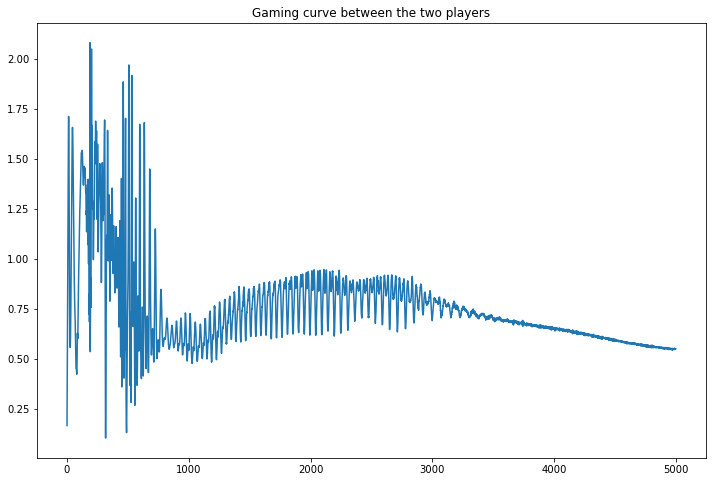

In [9]:
plt.figure(figsize = (12,8))
plt.plot(np.array(loss_trace))
plt.title("Gaming curve between the two players")

In [10]:
weights = model_reweighting(xi.to("cuda:0"))
weights /=weights.sum()
weights = weights.to("cpu").detach().numpy()

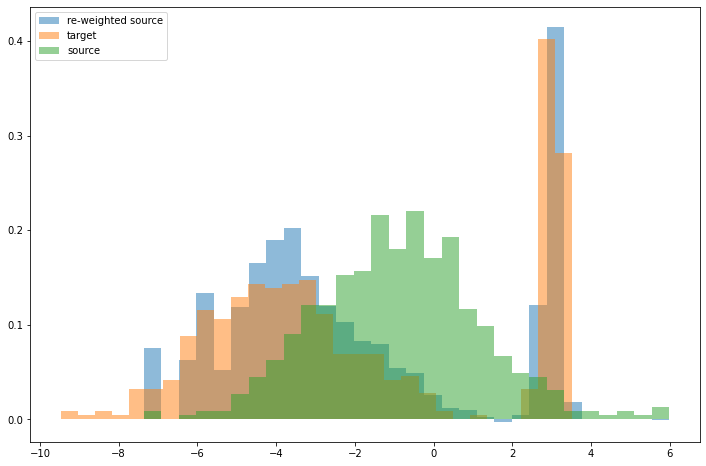

In [11]:
if_density = True
plt.figure(figsize = (12,8))
plt.hist(AB.xi[:,0].to("cpu").detach().numpy(), weights = weights*n, alpha = 0.5, bins = 30, label ="re-weighted source", density = if_density)
plt.hist(AB.xi_ring[:,0].to("cpu").detach().numpy(), alpha = 0.5, bins = 30, label ="target", density  = if_density)
plt.hist(AB.xi[:,0].to("cpu").detach().numpy(), alpha = 0.5, bins = 30, label ="source", density = if_density)
plt.legend()

In [12]:
model_reweighting(AB.xi).mean()

tensor(0.7349, device='cuda:0', grad_fn=<MeanBackward0>)

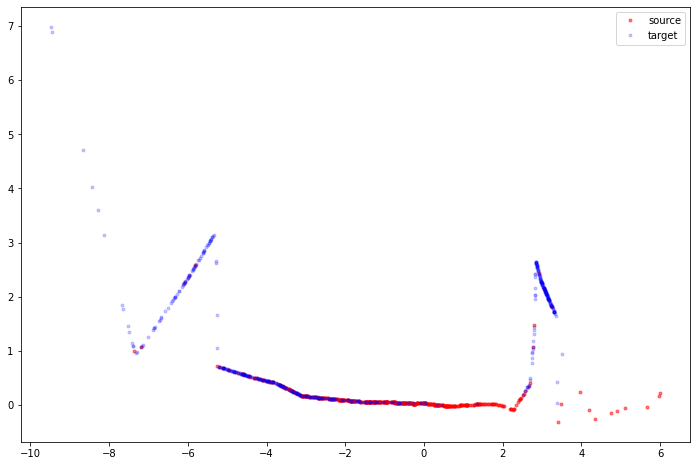

In [13]:
plt.figure(figsize = (12,8))
plt.plot(xi,model_IPM(AB.xi).to("cpu").detach().numpy(), "r.", alpha = 0.5, label="source")
plt.plot(xi_ring,model_IPM(AB.xi_ring).to("cpu").detach().numpy(), "b.", alpha = 0.2, label="target")
plt.legend()

In [14]:
# for name,x in model_IPM.named_parameters():
#     print(name)
#     print(x)

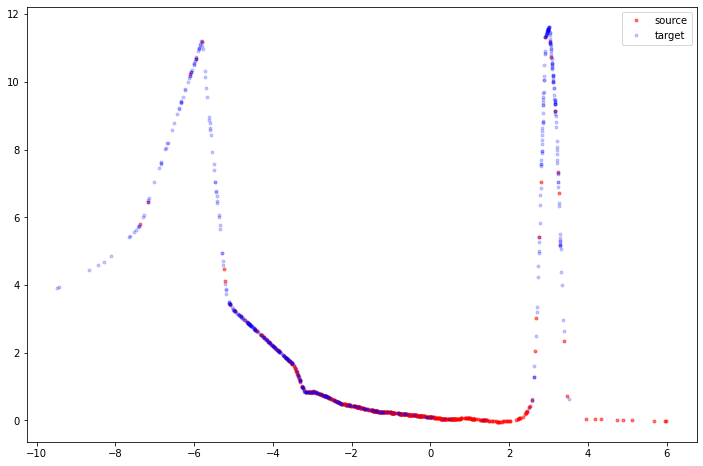

In [15]:

plt.figure(figsize = (12,8))
plt.plot(xi,model_reweighting(AB.xi).to("cpu").detach().numpy(), "r.", alpha = 0.5, label="source")
plt.plot(xi_ring,model_reweighting(AB.xi_ring).to("cpu").detach().numpy(), "b.", alpha = 0.2, label="target")
plt.legend()